<div>
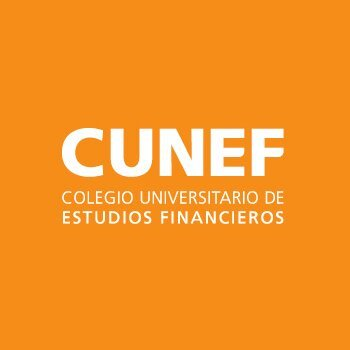
</div>

# **Número de vuelos de mercancías en España**
En este notebook se mostrará la serie temporal del **número de vuelos de mercancías en España** y observaremos cómo afectó ésta frente al COVID-19. 

Estructura del notebook:
    
    1) Librerías utilizadas
    2) Lectura y preprocesado de los datos
    3) EDA (Análisis Exploratorio de Datos)
    4) Elección del modelo predictivo
        4.1) Modelo de suavizado exponencial (ETS)
        4.2) Modelo autorregresivo integrado de media móvil (ARIMA)
        4.3) Modelo FB Prophet
    5) Predicción hasta finales de año 

## *1) Librerías utilizadas*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
from prophet import Prophet
from sktime.forecasting.arima import AutoARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots
from sktime.utils.plotting import plot_correlations
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.difference import Differencer
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
warnings.filterwarnings('ignore')

## *2) Lectura del csv y preprocesado de los datos*

Se procede a la lectura del CSV del tráfico aéreo en España, ofrecidos por AENA.
- Fuente: https://www.aena.es/es/estadisticas/inicio.html

In [2]:
df_vuelos = pd.read_excel("vuelos.xlsx")
df_vuelos = df_vuelos.set_index("Periodo")
df_vuelos

,Total Pasajeros,Total Mercancías
Periodo,,
2014-01-01,10959721,51279738
2014-02-01,10779086,51395821
2014-03-01,13446155,60074235
2014-04-01,16246439,55234845
2014-05-01,17540838,56289587
...,...,...
2022-02-01,11908046,78764432
2022-03-01,15587273,92308548
2022-04-01,20458260,82681716


Para este caso, estudiaremos únicamente el tráfico aéreo para las mercancías.

In [3]:
df_vuelos=df_vuelos.drop('Total Pasajeros', axis=1)
df_vuelos

,Total Mercancías
Periodo,
2014-01-01,51279738
2014-02-01,51395821
2014-03-01,60074235
2014-04-01,55234845
2014-05-01,56289587
...,...
2022-02-01,78764432
2022-03-01,92308548
2022-04-01,82681716


Chequeamos posibles valores faltantes en 'Total mercancías', en el caso de que los haya los rellenaríamos aplicando una media o bien aplicando el dato del mes anterior. 

In [4]:
df_vuelos.isnull().sum()

Total Mercancías    0
dtype: int64

No hay errores en los periodos observados, por lo que vamos a proceder a la realización del análisis exploratorio mediante gráficos y cálculos estadísticos. Pero antes vamos a realizar un rename de las columnas con el formato necesario para algunos modelos como el Prophet:

## *3) EDA*

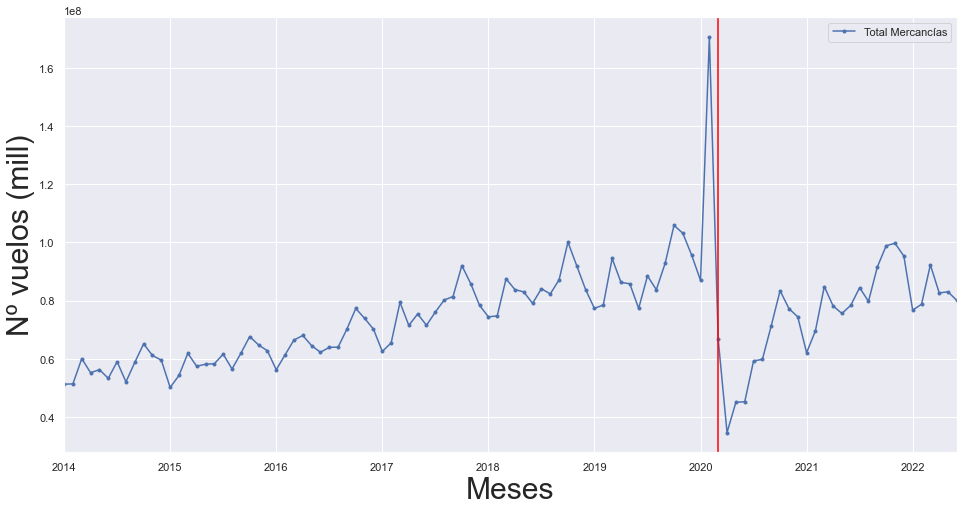

In [10]:
# Ploteamos nuestra serie temporal:
sns.set(rc={'figure.figsize':(16,8)})
fig = df_vuelos.plot(marker='.') 
fig.set_ylabel('Nº vuelos (mill)', fontsize = 30)
fig.axvline('2020-03-01', color = 'red', linewidth= 1.5)
fig.set_xlabel('Meses', fontsize = 30)
fig.figure.savefig('../pics/df_vuelos_mercancias/tendencia.png')

Como pasaba con los vuelos de turistas, **existía una tendencia creciente hasta la época COVID**, en la que se redujeron el número de vuelos de mercancías, en cambio parece estar recuperando los números.  


A continuación, analizaremos la estacionalidad y comprobaremos si la serie temporal es estacionaria mediante:
- Cálculo de la media y de la varianza
- Test de Dickey-Fuller aumentada
- Gráficas de comportamiento mensual
- Descomposición

### 3.1) Cálculo de la media y de la varianza

In [7]:
def split_and_summarize(dataframe, column, size, fn):
    ranges = []
    values = []
    for i in range(0, len(dataframe), size):
        ranges.append(dataframe[i:i + size])
    for i in ranges:
        values.append(fn(i[column]))
    return(values)

media=split_and_summarize(df_vuelos,'Total Mercancías',4,np.mean)
varianza=split_and_summarize(df_vuelos,'Total Mercancías',4,np.var)

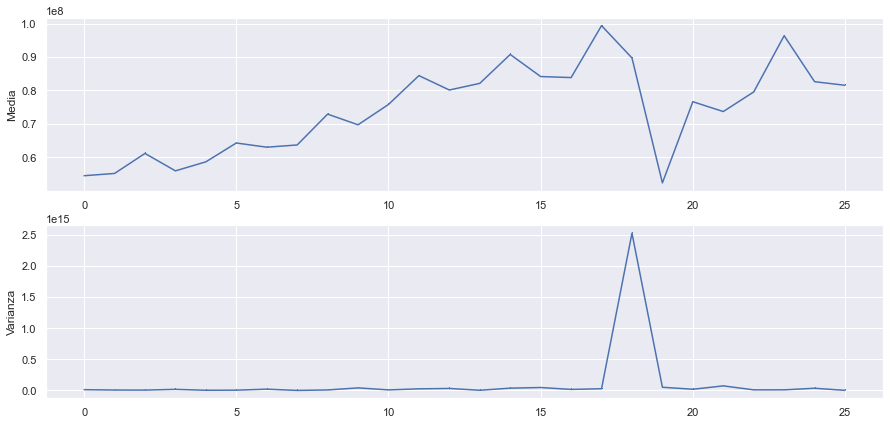

In [11]:
cols=['media','varianza']
df=pd.DataFrame([media,varianza], index=cols)

sns.set(rc={'figure.figsize':(15, 7)})
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(media, ',-')
ax1.set_ylabel('Media')

ax2.plot(varianza, ',-')
ax2.set_ylabel('Varianza')

plt.show()
# fig.figure.savefig('../pics/df_vuelos_mercancias/meanvariance.png')

A simple vista no parece una serie temporal estacionaria en cuanto a su media, pero la varianza, a pesar del pico del momento COVID-19, no queda muy claro si es estacionaria o no, por lo que procedemos a realizar la prueba de Dickey-Fuller aumentado.

### 3.2) Test de Dickey-Fuller aumentado

Esta prueba nos proporciona una verificación rápida y evidente de si la serie es estacionaria o no.

**La hipótesis nula (H0)** de la prueba es que la serie temporal se puede representar mediante una raíz unitaria, que no es estacionaria, es decir, que tiene alguna estructura dependiente del tiempo. 

**La hipótesis alternativa (H1)**, que rechaza la hipótesis nula, indica que la serie temporal es estacionaria.

Interpretamos este resultado utilizando el p-value. Un valor p por debajo del umbral de significancia (0.05) significa que la hipótesis nula se rechaza.


In [11]:
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df_vuelos)

Results of Dickey-Fuller Test:
Test Statistic                  -5.057070
p-value                          0.000017
#Lags Used                       0.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64


Pues resulta que **es una serie estacionaria** ya que su p-value es mucho menor que 0.05, eso significa que no habrá que realizar cambios en sus datos para los modelos.

### 3.3) Gráficas de comportamiento mensual

A continuación vamos a analizar con más detalle la estacionalidad y su tendencia:

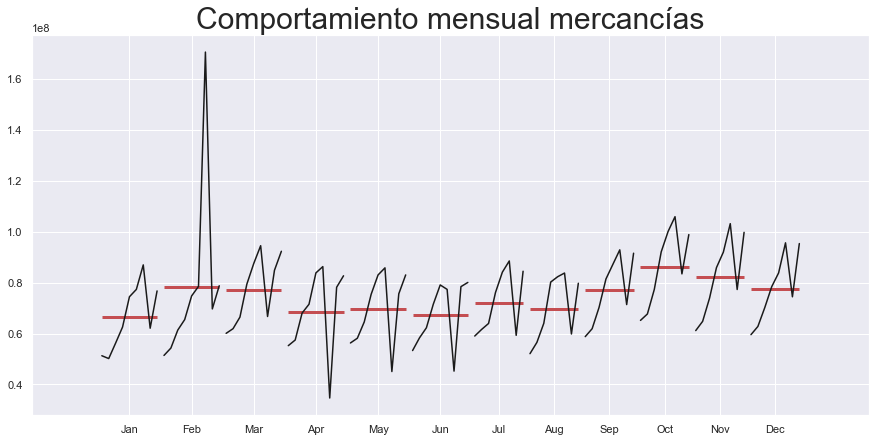

In [12]:
ax = plt.gca() 
sm.graphics.tsa.month_plot(df_vuelos['Total Mercancías'], ax = ax)
ax.set_title('Comportamiento mensual mercancías', fontsize = 30);
# ax.figure.savefig('../pics/df_vuelos_mercancias/monthbehavior.png')

Pasamos a realizar un boxplot mensual para estudiar las distribuciones:

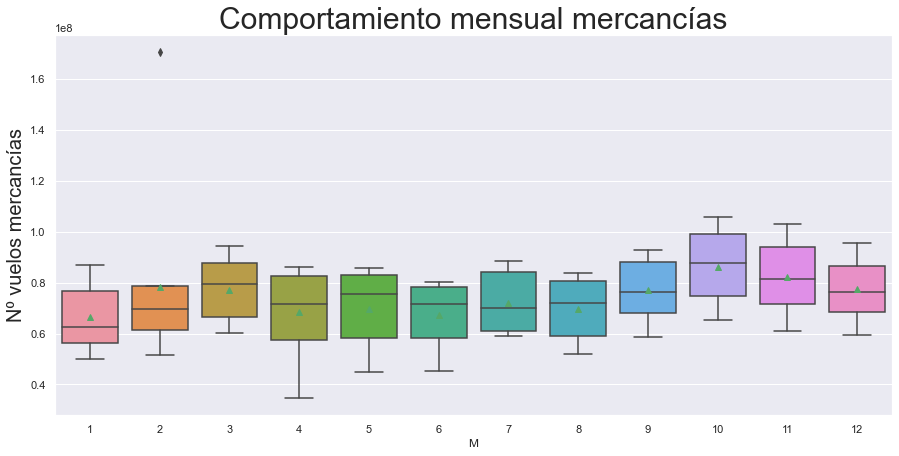

In [13]:
df_vuelos['M'] = df_vuelos.index.month
sns.boxplot(data = df_vuelos, x = 'M', y='Total Mercancías', showmeans=True)
ax = plt.gca()
ax.set_ylabel('Nº vuelos mercancías', fontsize = 20)
ax.set_title('Comportamiento mensual mercancías', fontsize = 30)
# ax.figure.savefig('../pics/df_vuelos_mercancias/boxplotmonth.png')

Por lo que podemos apreciar en las gráficas, parece que es constante el número de mercancías, por lo que **no existiría estacionalidad**.

Y, por último, el desglose de la estacionalidad, tendencia y residuos:

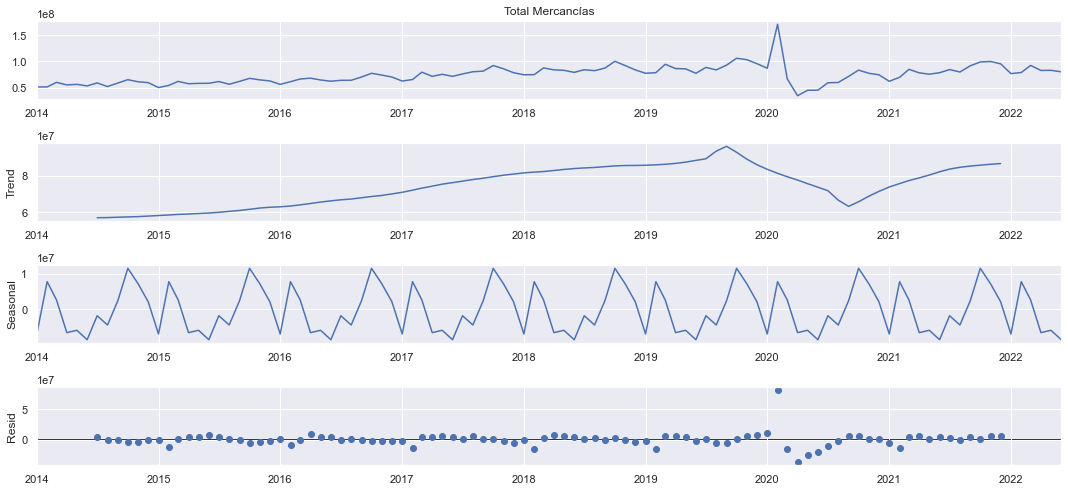

In [14]:
desglose_mercancias = seasonal_decompose(df_vuelos['Total Mercancías'], 
                                   model='additive', 
                                   period=12);
desglose_mercancias.plot()
# plt.savefig('../pics/df_vuelos_mercancias/decompose.png')

Como resumen del EDA:
- Tenía tendencia creciente hasta el inicio de la pandemia, decrece y a finales del mismo año recupera su tendencia creciente.
- Es una serie estacionaria a pesar de los picos que hay en la media y en la varianza.
- No tiene estacionalidad porque su número de vuelos es constante a lo largo del año.

## *4) Estimación mediante modelos*

### 4.1) Modelo de Suavizado Exponencial (ETS)

A continuación, se realiza una segmentación en la estimación y en la parte de predicción (Training-Testing), prediciéndolo en el tiempo que ha habido desde el inicio de la pandemia, es decir, desde marzo del 2020. Como el dataset tiene datos hasta julio del 2022, hay 29 meses para el test_size.



Cantidad de períodos en Train: 73
Cantidad de períodos en Test: 29


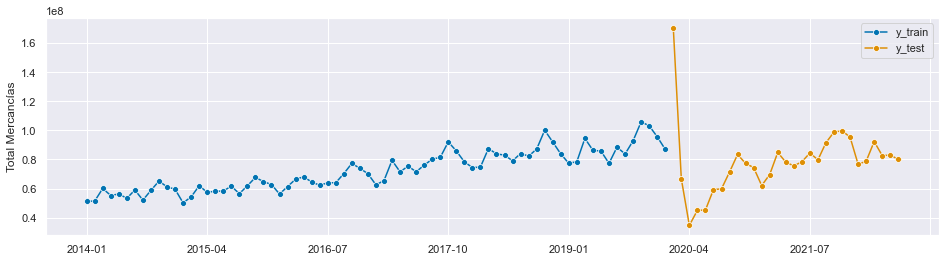

In [16]:
#Train-test
y_train, y_test = temporal_train_test_split(
    y=df_vuelos['Total Mercancías'].astype('float64').to_period('M'),test_size=29)
#Grafico para representar la separación de los datos
plot_series(y_train, y_test, labels=["y_train", "y_test"])
print('Cantidad de períodos en Train:', y_train.shape[0])
print('Cantidad de períodos en Test:', y_test.shape[0]);

In [17]:
y_test #observamos los 29 meses testeados

2020-02    170545811.0
2020-03     66692336.0
2020-04     34675815.0
2020-05     45074610.0
2020-06     45237114.0
2020-07     59292051.0
2020-08     59819175.0
2020-09     71369050.0
2020-10     83427468.0
2020-11     77289288.0
2020-12     74425632.0
2021-01     62086486.0
2021-02     69665926.0
2021-03     84846737.0
2021-04     78169207.0
2021-05     75589568.0
2021-06     78413351.0
2021-07     84468061.0
2021-08     79745681.0
2021-09     91548451.0
2021-10     98862149.0
2021-11     99742359.0
2021-12     95332962.0
2022-01     76730972.0
2022-02     78764432.0
2022-03     92308548.0
2022-04     82681716.0
2022-05     83021678.0
2022-06     80067687.0
Freq: M, Name: Total Mercancías, dtype: float64

Se realiza el pronóstico (forecasting) del horizonte temporal de 2 años. En sp, que es el número de periodos en un ciclo estacional completo, pondremos 12 para datos mensuales con ciclo anual:

In [18]:
# Especifico la cantidad de períodos a estimar para obtener las observaciones predichas en test.
fh = np.arange(1, y_test.shape[0]+1)

# Selecciono el modelo y sus parámetros de predicción, al igual que los recursos a utilizar para entrenar
vuelos_auto_ets = AutoETS(auto=True, sp=12, n_jobs=-1)

In [19]:
vuelos_auto_ets.fit(y_train)
vuelos_auto_ets.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:       Total Mercancías   No. Observations:                   73
Model:                       ETS(MAM)   Log Likelihood               -1175.043
Date:                Sat, 27 Aug 2022   AIC                           2386.086
Time:                        11:43:41   BIC                           2427.314
Sample:                    01-31-2014   HQIC                          2402.516
                         - 01-31-2020   Scale                            0.001
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5824      0.143      4.060      0.000       0.301       0.863
smoothing_trend      5.824e-05        nan        nan        nan         nan         nan
smoothing_seasonal   4.176e-05        nan        nan        nan         nan         nan
initial_level        5.647e+07        nan        nan        nan         nan         nan
initial_trend        2.393e+05   1.53e+05      1.559      0.119   -6.16e+04     5.4e+05
initial_seasonal.0      1.1116      0.077     14.432      0.000       0.961       1.263
initial_seasonal.1      1.1901      0.083     14.253      0.000       1.026       1.354
initial_seasonal.2      1.2672      0.087     14.599      0.000       1.097       1.437
initial_seasonal.3      1.1396      0.078     14.583      0.000       0.986       1.293
initial_seasonal.4      1.0618      0.070     15.106      0.000       0.924       1.200
initial_seasonal.5      1.1084      0.074     15.027      0.000       0.964       1.253
initial_seasonal.6      1.0373      0.072     14.506      0.000       0.897       1.177
initial_seasonal.7      1.0960      0.077     14.243      0.000       0.945       1.247
initial_seasonal.8      1.1018      0.076     14.576      0.000       0.954       1.250
initial_seasonal.9      1.1805      0.079     15.031      0.000       1.027       1.334
initial_seasonal.10     1.0230      0.067     15.378      0.000       0.893       1.153
initial_seasonal.11     1.0000      0.056     17.846      0.000       0.890       1.110
===================================================================================
Ljung-Box (Q):                       12.78   Jarque-Bera (JB):                 2.54
Prob(Q):                              0.54   Prob(JB):                         0.28
Heteroskedasticity (H):               0.38   Skew:                            -0.18
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.3e+20. Standard errors may be unstable.
"""

In [20]:
#step 5: querying predictions
vuelos_pred = vuelos_auto_ets.predict(fh=list(fh))
vuelos_pred.round()

2020-02     88764499.0
2020-03    102715127.0
2020-04     96134564.0
2020-05     95892410.0
2020-06     91000161.0
2020-07     97506140.0
2020-08     93661626.0
2020-09    100802626.0
2020-10    112390790.0
2020-11    105839171.0
2020-12     99126606.0
2021-01     89413540.0
2021-02     91717352.0
2021-03    106122618.0
2021-04     99314958.0
2021-05     99056071.0
2021-06     93994186.0
2021-07    100705449.0
2021-08     96726411.0
2021-09    104092108.0
2021-10    116048481.0
2021-11    109274327.0
2021-12    102335218.0
2022-01     92299966.0
2022-02     94670205.0
2022-03    109530109.0
2022-04    102495352.0
2022-05    102219732.0
2022-06     96988212.0
Freq: M, dtype: float64

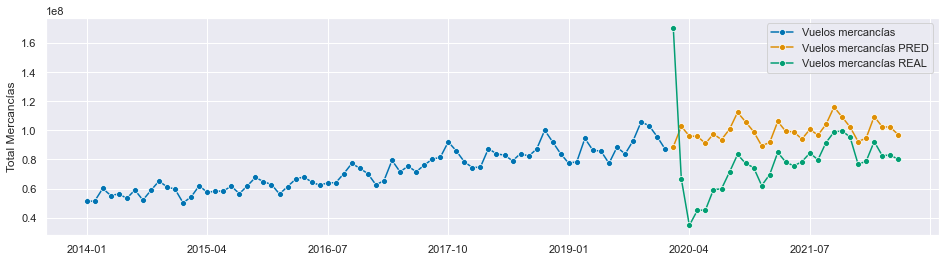

In [21]:
# optional: plotting predictions and past data
plot_series(y_train, vuelos_pred, y_test,labels=[
    "Vuelos mercancías", "Vuelos mercancías PRED", "Vuelos mercancías REAL"]);

Se hace un zoom al gráfico:

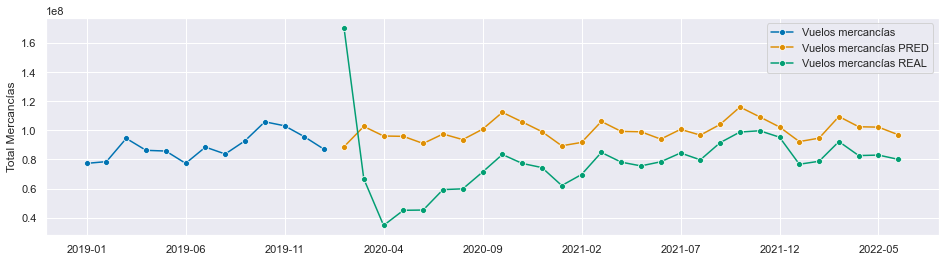

In [23]:
plot_series(y_train["2019":], vuelos_pred,y_test, labels=[
    "Vuelos mercancías", "Vuelos mercancías PRED", "Vuelos mercancías REAL"]);

La predicción por ETS, a simple vista, no predice en absoluto el momento COVID, pero a partir de después del verano del 2021 sí que afina más su precisión. Vamos a calcular el error de las predicciones mediante el RMSE y MAPE. 

In [24]:
mse = MeanSquaredError(square_root=True)
mse_ets = mse(y_test, vuelos_pred)
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))

El modelo ETS genera un RMSE de: 31120498.66


In [67]:
mape = MeanAbsolutePercentageError(symmetric=True)
mape_ets = mape(y_test, vuelos_pred)
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))

El modelo ETS genera un MAPE de: 31.26%


### 4.2) Modelo ARIMA

Al tratarse de una serie estacionaria, no tenemos que transformar la serie.

73 29


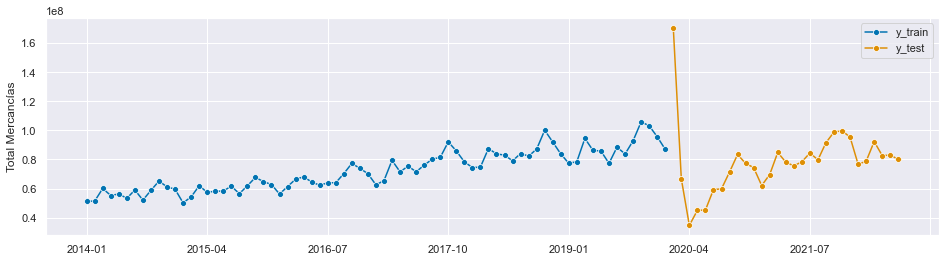

In [27]:
y_train_arima,y_test_arima=temporal_train_test_split(
    y=df_vuelos['Total Mercancías'].astype('float64').to_period('M').sort_index(),test_size=29)
plot_series(y_train_arima, y_test_arima, labels=["y_train", "y_test"])
print(y_train_arima.shape[0], y_test_arima.shape[0])
plt.show()

Generamos el modelo y se entrena con los datos del train:

In [28]:
fh = np.arange(1,y_test_arima.shape[0]+1)
vuelos_auto_arima=AutoARIMA(sp=12,suppress_warnings=True)

In [29]:
vuelos_auto_arima.fit(y_train_arima)
vuelos_auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                   73
Model:             SARIMAX(1, 0, 0)x(2, 1, [1, 2], 12)   Log Likelihood                -995.749
Date:                                 Sat, 27 Aug 2022   AIC                           2005.497
Time:                                         11:49:19   BIC                           2020.273
Sample:                                              0   HQIC                          2011.288
                                                  - 73                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.005e+06   1.75e-08   1.72e+14      0.000       3e+06       3e+06
ar.L1         -0.0171      0.062     -0.275      0.783      -0.139       0.105
ar.S.L12       1.0016      0.245      4.086      0.000       0.521       1.482
ar.S.L24      -0.5785      0.250     -2.315      0.021      -1.068      -0.089
ma.S.L12      -1.0650      0.221     -4.820      0.000      -1.498      -0.632
ma.S.L24       0.6969      0.239      2.911      0.004       0.228       1.166
sigma2      9.469e+12   2.63e-14    3.6e+26      0.000    9.47e+12    9.47e+12
===================================================================================
Ljung-Box (L1) (Q):                   5.81   Jarque-Bera (JB):                 0.05
Prob(Q):                              0.02   Prob(JB):                         0.98
Heteroskedasticity (H):               2.72   Skew:                             0.06
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.56e+42. Standard errors may be unstable.
"""

In [30]:
vuelos_pred_arima = vuelos_auto_arima.predict(fh)
vuelos_pred_arima

2020-02    8.211496e+07
2020-03    9.827424e+07
2020-04    9.021365e+07
2020-05    8.985664e+07
2020-06    8.148818e+07
2020-07    9.225832e+07
2020-08    8.834851e+07
2020-09    9.671265e+07
2020-10    1.100263e+08
2020-11    1.067237e+08
2020-12    9.875598e+07
2021-01    9.070455e+07
2021-02    8.572331e+07
2021-03    1.021689e+08
2021-04    9.385924e+07
2021-05    9.349847e+07
2021-06    8.477833e+07
2021-07    9.596717e+07
2021-08    9.178979e+07
2021-09    1.002077e+08
2021-10    1.137211e+08
2021-11    1.104831e+08
2021-12    1.023544e+08
2022-01    9.573901e+07
2022-02    9.014704e+07
2022-03    1.068403e+08
2022-04    9.819107e+07
2022-05    9.774912e+07
2022-06    8.862591e+07
Freq: M, dtype: float64

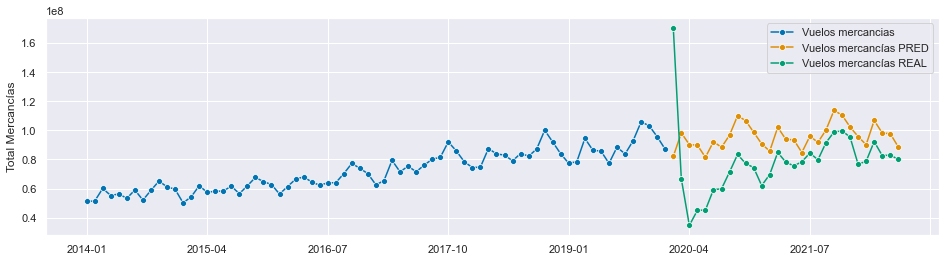

In [31]:
# representamos la serie predictiva
plot_series(y_train_arima, vuelos_pred_arima, y_test_arima,
            labels=["Vuelos mercancias", "Vuelos mercancías PRED", "Vuelos mercancías REAL"])
plt.show()

In [32]:
mse = MeanSquaredError(square_root=True)
mse_arima = mse(y_test_arima, vuelos_pred_arima)
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))

El modelo ARIMA genera un RMSE de: 28698826.55


In [68]:
mape = MeanAbsolutePercentageError(symmetric=True)
mape_arima = mape(y_test_arima, vuelos_pred_arima)
print('El modelo ARIMA genera un MAPE de: {}%'.format(round(mape_arima*100,2)))

El modelo ARIMA genera un MAPE de: 27.77%


#### Una comparativa entre ETS y ARIMA

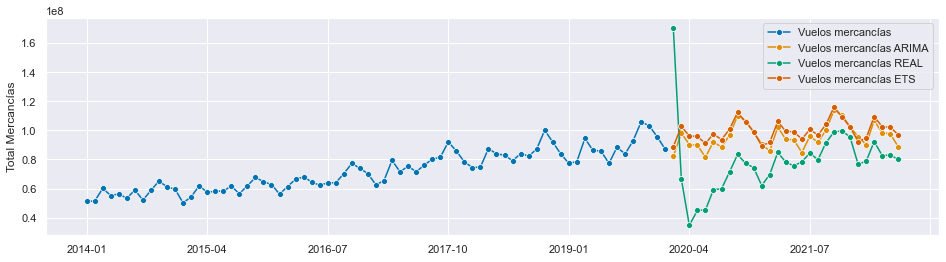

In [34]:
plot_series(y_train_arima["2013":], vuelos_pred_arima, y_test_arima, vuelos_pred, 
            labels=["Vuelos mercancías", "Vuelos mercancías ARIMA", "Vuelos mercancías REAL", 
                    'Vuelos mercancías ETS'])
plt.show()
# plt.savefig('../pics/df_vuelos_mercancias/etsarima.png')

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [35]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))

El modelo ETS genera un RMSE de: 31120498.66
El modelo ARIMA genera un RMSE de: 28698826.55


In [36]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_arima*100,2)))

El modelo ETS genera un MAPE de: 39.82%
El modelo ARIMA genera un MAPE de 34.32%


Confirmamos que el modelo ARIMA, para este caso concreto, predice algo mejor ya que su error es menor.

### 4.3) Prophet

FB Prophet es un modelo muy extendido para la predicción de series temporales desarrollado por Facebook. El objetivo de este paquete es dar a los usuarios una herramienta potente y de fácil uso para predecir resultados de distintas series temporales. Este modelo alcanza sus mejores resultados con series estacionarias o series con una tendencia y estacionalidad marcadas, como es el caso del turismo en España. Suele ser peor cuando aumenta la aleatoria de la muestra. 

Dentro de nuestro DataFrame cambiamos el nombre de la columna temporal *'Periodo'* y la de la variable objetivo *'Total'* por *'ds'* e *'y'*, y también quitamos el Periodo como índice, pues todos estos cambios son necesarios para que el modelo funcione bien.

In [49]:
df_vuelos_prophet=pd.read_excel("vuelos.xlsx")
df_vuelos_prophet=df_vuelos_prophet.drop('Total Pasajeros',axis=1)
df_vuelos_prophet

,Periodo,Total Mercancías
0,2014-01-01,51279738
1,2014-02-01,51395821
2,2014-03-01,60074235
3,2014-04-01,55234845
4,2014-05-01,56289587
...,...,...
97,2022-02-01,78764432
98,2022-03-01,92308548
99,2022-04-01,82681716
100,2022-05-01,83021678


In [51]:
prophet_train = df_vuelos_prophet #cambiamos de índice
prophet_train.columns = ['ds', 'y'] #renombramos las columnas

In [52]:
prophet_y_train = y_train.copy()
prophet_y_train = prophet_y_train.rename_axis('index').reset_index()
prophet_y_train.columns = ['ds', 'y']
prophet_y_train['ds'] = prophet_y_train['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_train)

73

In [53]:
prophet_y_test = y_test.copy()
prophet_y_test = prophet_y_test.rename_axis('index').reset_index()
prophet_y_test.columns = ['ds', 'y']
prophet_y_test['ds'] = prophet_y_test['ds'].dt.to_timestamp(freq = 'M')
len(prophet_y_test)

29

In [54]:
prophet_y_train.tail()

,ds,y
68,2019-09-30,92862462.0
69,2019-10-31,105893396.0
70,2019-11-30,103152527.0
71,2019-12-31,95623604.0
72,2020-01-31,86957539.0


In [55]:
prophet_y_test.head()

,ds,y
0,2020-02-29,170545811.0
1,2020-03-31,66692336.0
2,2020-04-30,34675815.0
3,2020-05-31,45074610.0
4,2020-06-30,45237114.0


In [56]:
m = Prophet()
m.fit(prophet_y_train)

11:59:24 - cmdstanpy - INFO - Chain [1] start processing
11:59:25 - cmdstanpy - INFO - Chain [1] done processing


In [57]:
m_pred = m.make_future_dataframe(periods=len(prophet_y_test), freq='M')
prophet_forecast = m.predict(m_pred)

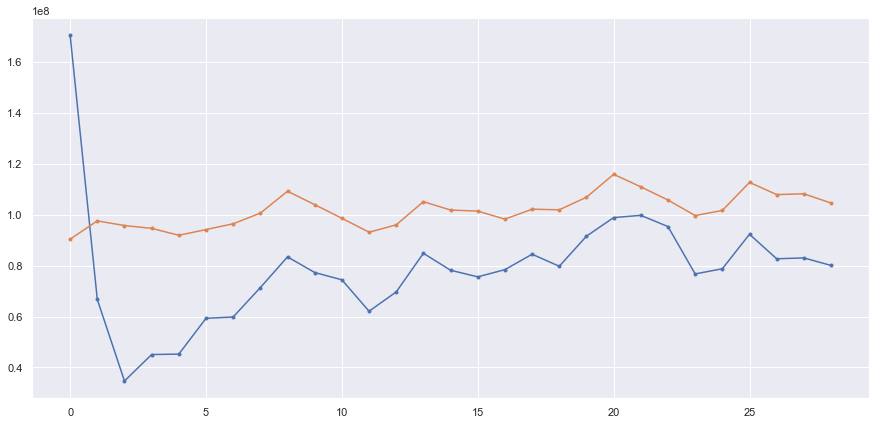

In [61]:
plt.plot(list(prophet_y_test['y']), '.-')
plt.plot(list(prophet_forecast.loc[73:, 'yhat']), '.-', label='Predicition')
plt.show()
# plt.savefig('../pics/df_vuelos_mercancias/prophet.png')

In [69]:
# Forecast Accuracy
# MAPE
# mape_prophet = mean_absolute_percentage_error(prophet_y_test['y'], prophet_forecast.loc[47:, 'yhat'])
# mape_prophet

mape = MeanAbsolutePercentageError(symmetric=True)
mape_prophet = mape(prophet_y_test['y'], prophet_forecast.loc[73:, 'yhat'])
print('El modelo Prophet genera un MAPE de: {}%'.format(round(mape_prophet*100,2)))

El modelo Prophet genera un MAPE de: 33.08%


In [63]:
# Forecast Accuracy
#Mean Squared Error
mse = MeanSquaredError(square_root=True)
mse_prophet = mse(prophet_y_test['y'],prophet_forecast.loc[73:, 'yhat'])
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo Prophet genera un RMSE de: 32001336.64


In [64]:
prophet_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
97,2022-02-28,101656121.0,98242400.0,105165850.0
98,2022-03-31,112690701.0,109062322.0,116221425.0
99,2022-04-30,107894683.0,104166562.0,111829910.0
100,2022-05-31,108194496.0,104666133.0,111966985.0
101,2022-06-30,104587511.0,100554181.0,108384103.0


### 4.4) Comparativa errores y elección del mejor modelo

Ahora comparamos entre las métricas de error que tenemos:
1) RMSE (Error dependiente de la escala)

In [65]:
print('El modelo ETS genera un RMSE de:', round(mse_ets,2))
print('El modelo ARIMA genera un RMSE de:', round(mse_arima,2))
print('El modelo Prophet genera un RMSE de:', round(mse_prophet,2))

El modelo ETS genera un RMSE de: 31120498.66
El modelo ARIMA genera un RMSE de: 28698826.55
El modelo Prophet genera un RMSE de: 32001336.64


2) MAPE (Error porcentual)

In [70]:
print('El modelo ETS genera un MAPE de: {}%'.format(round(mape_ets*100,2)))
print('El modelo ARIMA genera un MAPE de {}%'.format(round(mape_arima*100,2)))
print('El modelo Prophet genera un MAPE de {}%'.format(round(mape_prophet*100,2)))

El modelo ETS genera un MAPE de: 31.26%
El modelo ARIMA genera un MAPE de 27.77%
El modelo Prophet genera un MAPE de 33.08%


Confirmamos que **el mejor modelo para la predicción de esta serie temporal es la ARIMA**, ya que es el que mejor se ajusta a los datos reales y es el que menor error da, aunque se considera que es un error un poco elevado.

## *5) Predicción hasta finales de año*

A continuación realizamos la predicción de la serie temporal del número de vuelos de pasajeros hasta finales de año, es decir, hasta diciembre del 2022. Como es estacionaria la serie no hay que pasarlo primero a logaritmo y luego a números normales:

In [71]:
fh = np.arange(1,7)
autoarima_predict = AutoARIMA(sp=12,suppress_warnings=True)
y = df_vuelos['Total Mercancías'].astype('float64').to_period('M')
autoarima_predict.fit(y)

AutoARIMA(sp=12, suppress_warnings=True)

In [72]:
# Modelo AutoARIMA:

print(autoarima_predict.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  102
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1803.786
Date:                Sun, 28 Aug 2022   AIC                           3613.572
Time:                        10:36:32   BIC                           3621.417
Sample:                             0   HQIC                          3616.748
                                - 102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4073      0.068      5.985      0.000       0.274       0.541
ma.L1         -0.8718      0.056    -15.579      0.000      -0.982      -0.762
sigma2      2.037e+14        nan        nan        n

In [73]:
vuelosnew_pred = autoarima_predict.predict(fh=list(fh))
vuelosnew_pred.round()

2022-07    81972540.0
2022-08    82748345.0
2022-09    83064313.0
2022-10    83193000.0
2022-11    83245411.0
2022-12    83266757.0
Freq: M, dtype: float64

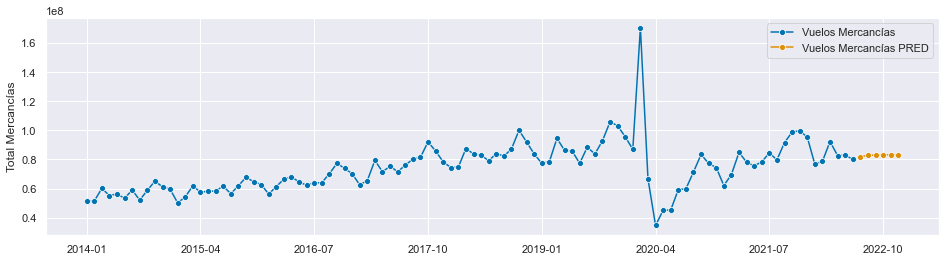

In [74]:
# Representamos gráficamente:
plot_series(y, vuelosnew_pred, labels=["Vuelos Mercancías", "Vuelos Mercancías PRED"])
# plt.savefig('../pics/df_vuelos_mercancias/predict2022.png')